<a href="https://colab.research.google.com/github/larixgomex/customer_segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overview

Wolt, a popular online food delivery company, recognizes the importance of understanding their user base to better serve their customers. To achieve this, I'll create a detailed user segmentation based on the available data.

The dataset I'm working with consists of some machine-generated user data of a food delivery application. Each row represents a unique customer who has registered to use the service from September 2019 to October 2020. During this period, the customers might have made purchases from the app or not.

### Objective



To accomplish this goal, I'm performing a RFM (Recency, Frequency, Monetary) analysis. This analysis will allow to segment their users into distinct groups based on their purchasing behavior, such as the frequency of orders, the amount spent, and how recently they placed their last order. By doing so, Wolt will be able to identify their most valuable customers and determine the areas that require more attention in order to retain them.

The insights gained from this analysis will enable the company to tailor their services to meet the needs of different user segments. For instance, they may offer personalized discounts to users who have not ordered in a while, or they may provide a better loyalty program to their most frequent users.

**Steps**

*   Data Preprocessing & Exploration
*   Data Cleaning & Initial Analysis
*   RFM Analysis
*   Evaluating the Skewness and Scaling
*   K-Means Analysis with elbow method
*   Analysis of the Clusters
*   Interpretation of the Results



## ⚙️ Config

**Libraries**

In [ ]:
### Installing dependencies ###
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt


**Functions**

In [ ]:
# percentage of missing data for each column

def initial_review_table(df):
    isnull = df.isnull().sum()
    type_columns = df.dtypes
    pre = round((isnull/len(df))*100, 2)
    dc = pd.DataFrame({"Type":type_columns,
                       "Isnull":isnull,
                       "Missing data ٪":pre})
    print(dc.sort_values(by = "Missing data ٪", ascending = False))

In [ ]:
# counts the number of days between the registration date and the first order date.

def first_order(df):
    registr_date = df['registration_date']
    order_date = df['first_purchase_day']
    wating_day = order_date - registr_date
    total = len(wating_day)
    wating_table = pd.DataFrame({"Wating_day": wating_day, "count": 1})
    count_wating_day = wating_table.groupby(["Wating_day"]).count().sort_values("count", ascending = False)
    count_wating_day.reset_index(drop = True, inplace = True)
    count_wating_day["percentage %"] = (count_wating_day["count"]/total)*100
    return count_wating_day

def first_order_plot():
    first_or = first_order(df)
    plt.plot(first_or["percentage %"], "-", color = "#C71585")
    plt.ylabel("first order", size = 12, c = "black")
    plt.xlabel("days", size = 12, c = "black")
    plt.title("How long does it take until the first order after registration", size = 12, color = "black")
    plt.show()

**Colors**

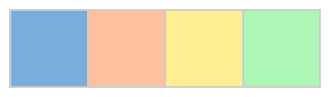

In [ ]:
# custom palette
customPalette = ['#79ADDC','#FFC09F','#FFEE93','#ADF7B6']
sns.set_palette(customPalette)
sns.palplot(customPalette)

# for plotly
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4']

## 🌈 Data Preprocessing and Exploration

In [ ]:
df = pd.read_csv('dataset_for_analyst_assignment_20201120.csv')
df.head()
print(list(df))

['REGISTRATION_DATE', 'REGISTRATION_COUNTRY', 'PURCHASE_COUNT', 'PURCHASE_COUNT_DELIVERY', 'PURCHASE_COUNT_TAKEAWAY', 'FIRST_PURCHASE_DAY', 'LAST_PURCHASE_DAY', 'USER_ID', 'BREAKFAST_PURCHASES', 'LUNCH_PURCHASES', 'EVENING_PURCHASES', 'DINNER_PURCHASES', 'LATE_NIGHT_PURCHASES', 'TOTAL_PURCHASES_EUR', 'DISTINCT_PURCHASE_VENUE_COUNT', 'MIN_PURCHASE_VALUE_EUR', 'MAX_PURCHASE_VALUE_EUR', 'AVG_PURCHASE_VALUE_EUR', 'PREFERRED_DEVICE', 'IOS_PURCHASES', 'WEB_PURCHASES', 'ANDROID_PURCHASES', 'PREFERRED_RESTAURANT_TYPES', 'USER_HAS_VALID_PAYMENT_METHOD', 'MOST_COMMON_HOUR_OF_THE_DAY_TO_PURCHASE', 'MOST_COMMON_WEEKDAY_TO_PURCHASE', 'AVG_DAYS_BETWEEN_PURCHASES', 'MEDIAN_DAYS_BETWEEN_PURCHASES', 'AVERAGE_DELIVERY_DISTANCE_KMS', 'PURCHASE_COUNT_BY_STORE_TYPE']


In [ ]:
# lower case the columns for readability
df.columns = df.columns.str.lower()
df.head()

,registration_date,registration_country,purchase_count,purchase_count_delivery,purchase_count_takeaway,first_purchase_day,last_purchase_day,user_id,breakfast_purchases,lunch_purchases,...,web_purchases,android_purchases,preferred_restaurant_types,user_has_valid_payment_method,most_common_hour_of_the_day_to_purchase,most_common_weekday_to_purchase,avg_days_between_purchases,median_days_between_purchases,average_delivery_distance_kms,purchase_count_by_store_type
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,...,0.0,1.0,NaN,False,23.0,2.0,NaN,NaN,6.853,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,...,19.0,0.0,NaN,True,21.0,2.0,9.0,3.0,6.559,"{\n ""General merchandise"": 1,\n ""Grocery"": 9..."
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."
4,2019-09-01 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,5,NaN,NaN,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,"{\n ""General merchandise"": 0,\n ""Grocery"": 0..."


In [ ]:
# load the store type column
import json
purchase_df = df['purchase_count_by_store_type'].apply(json.loads)
purchase_df = pd.DataFrame(purchase_df.tolist())
purchase_df

,General merchandise,Grocery,Pet supplies,Restaurant,Retail store
0,0,0,0,0,0
1,0,0,0,1,0
2,1,9,0,9,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
21978,0,0,0,1,0
21979,0,0,0,0,0
21980,0,0,0,0,0
21981,0,0,0,0,0


## ⚡️ Data Cleaning & Initial Findings

In [ ]:
# append store type to the df
df = pd.merge(df, purchase_df, left_index=True, right_index=True)
df = df.drop(['purchase_count_by_store_type'],axis=1)
df.head()

,registration_date,registration_country,purchase_count,purchase_count_delivery,purchase_count_takeaway,first_purchase_day,last_purchase_day,user_id,breakfast_purchases,lunch_purchases,...,most_common_hour_of_the_day_to_purchase,most_common_weekday_to_purchase,avg_days_between_purchases,median_days_between_purchases,average_delivery_distance_kms,General merchandise,Grocery,Pet supplies,Restaurant,Retail store
0,2019-09-01 00:00:00.000,DNK,0,NaN,NaN,NaN,NaN,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2019-09-01 00:00:00.000,FIN,1,1.0,0.0,2020-09-02 00:00:00.000,2020-09-02 00:00:00.000,2,0.0,1.0,...,23.0,2.0,NaN,NaN,6.853,0,0,0,1,0
2,2019-09-01 00:00:00.000,DNK,19,19.0,0.0,2019-12-10 00:00:00.000,2020-05-25 00:00:00.000,3,0.0,4.0,...,21.0,2.0,9.0,3.0,6.559,1,9,0,9,0
3,2019-09-01 00:00:00.000,FIN,0,NaN,NaN,NaN,NaN,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
4,2019-09-01 00:00:00.000,GRC,0,NaN,NaN,NaN,NaN,5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [ ]:
initial_review_table(df)


                                            Type  Isnull  Missing data ٪
preferred_restaurant_types                object   19289           87.75
median_days_between_purchases            float64   14151           64.37
avg_days_between_purchases               float64   14151           64.37
first_purchase_day                        object   10019           45.58
last_purchase_day                         object    9956           45.29
average_delivery_distance_kms            float64    9955           45.28
most_common_weekday_to_purchase          float64    9955           45.28
most_common_hour_of_the_day_to_purchase  float64    9955           45.28
android_purchases                        float64    9955           45.28
web_purchases                            float64    9955           45.28
ios_purchases                            float64    9955           45.28
max_purchase_value_eur                   float64    9955           45.28
min_purchase_value_eur                   float64   

In [ ]:
df.drop(["preferred_restaurant_types","median_days_between_purchases","avg_days_between_purchases"],axis=1,inplace=True)
df.dropna(inplace=True)

👉 Note that the analysis we are conducting does not involve users who have registered but have not made any purchase. However, before deleting such users, it is important to ensure that they do not constitute a significant sample that could affect our analysis in the future.

In [ ]:
df_new_clients = df[df['purchase_count']== 0]
df = df[df['purchase_count'] != 0]
# Convert 'registration_date' 'first_purchase_day' and 'last_purchase_day' to datetime
df['registration_date'] = pd.to_datetime(df['registration_date']).dt.date
df['first_purchase_day'] = pd.to_datetime(df['first_purchase_day']).dt.date
df['last_purchase_day'] = pd.to_datetime(df['last_purchase_day']).dt.date


Now let's take a look at the trends in our customers' first order.

In [ ]:
first_order(df).head(8)


,count,percentage %
0,5834,48.767032
1,414,3.460670
2,188,1.571512
3,118,0.986375
4,83,0.693806
5,80,0.668729
6,78,0.652010
7,69,0.576778


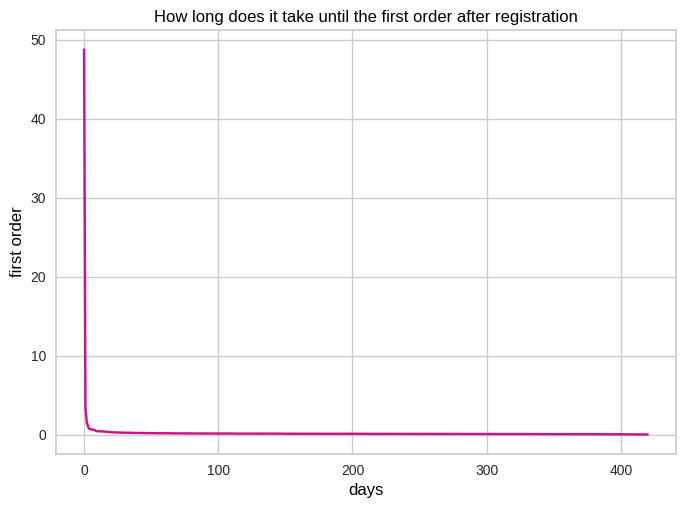

In [ ]:
first_order_plot()

We can see that almost half of the customers place their first order on the same day as their registration. However, the number of first-time orders decreases rapidly thereafter, following a pattern similar to that of an exponential decay function. On the second day, only 4% of customers place their first order, and this further reduces to less than 2% on the third day.

Based on this trend, the third day provides an ideal opportunity for the marketing team to engage customers proactively and encourage them to place an order. At this point, customers may still be open to promotional offers or incentives that can motivate them to make a purchase. By taking advantage of this window of opportunity, the marketing team can effectively utilize customer behavior and boost order activity.

## 🌓 Creating RFM Values and Table

In [ ]:
print('The most recent date overall: '+ str(df['last_purchase_day'].max()))

The most recent date overall: 2020-10-31


In [ ]:
today_date = dt.datetime(2020, 11, 2)
df['recency'] = (today_date - pd.to_datetime(df['last_purchase_day'])).dt.days
df['frequency'] = df['purchase_count']
df['monetary'] = df['total_purchases_eur']
rfm = df[['user_id','recency', 'frequency', 'monetary']]
rfm

,user_id,recency,frequency,monetary
1,2,61,1,38.456
2,3,161,19,631.488
7,8,19,1,19.228
12,13,6,19,587.972
13,14,54,2,118.404
...,...,...,...,...
21973,21974,18,1,26.312
21975,21976,189,4,22.264
21976,21977,396,1,56.672
21978,21979,284,1,26.312


In [ ]:
rfm["recency_score"] = pd.qcut(rfm['recency'] , q = 5 , labels=[5,4,3,2,1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm["monetary"], 5, labels=[1, 2, 3, 4, 5])
rfm["rfm_score"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [ ]:
rfm.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
1,2,61,1,38.456,4,1,2,41
2,3,161,19,631.488,3,5,5,35
7,8,19,1,19.228,5,1,1,51
12,13,6,19,587.972,5,5,5,55
13,14,54,2,118.404,4,2,4,42


In [ ]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_lose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['rfm_score'].replace(seg_map, regex=True)
rfm.tail()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segment
21973,21974,18,1,26.312,5,2,1,52,potential_loyalists
21975,21976,189,4,22.264,3,4,1,34,loyal_customers
21976,21977,396,1,56.672,2,2,3,22,hibernating
21978,21979,284,1,26.312,2,2,1,22,hibernating
21982,21983,398,1,6.072,2,2,1,22,hibernating


In [ ]:
segment_analysis = rfm.groupby('segment').agg({'recency': "mean",
                                                "frequency": "mean",
                                                "monetary": "mean",
                                                "segment": "count"})
segment_analysis.columns = ['recency(mean)', 'frequency(mean)', 'monetary(mean)', "count"]
segment_analysis

,recency(mean),frequency(mean),monetary(mean),count
segment,,,,
about_to_sleep,171.582880,1.243207,39.792500,736
at_risk,339.031837,3.162449,95.048692,1225
cant_lose,308.419118,17.889706,405.529235,136
champions,10.431866,16.634172,463.807874,1908
hibernating,393.843970,1.088993,34.636115,3416
loyal_customers,94.114488,10.804746,314.466571,2402
need_attention,169.920280,2.579021,86.368185,715
new_customers,13.282609,1.000000,25.795000,92
potential_loyalists,40.252159,2.251295,70.981575,1158


In [ ]:
rfm.groupby('rfm_score').agg(
    customers=('segment', 'count'),
    mean_recency=('recency', 'mean'),
    mean_frequency=('frequency', 'mean'),
    mean_monetary=('monetary', 'mean'),
).sort_values(by='rfm_score')

,customers,mean_recency,mean_frequency,mean_monetary
rfm_score,,,,
11,1453,419.599449,1.000000,32.154158
12,723,408.800830,1.136929,34.589964
13,107,409.878505,2.411215,73.100449
14,20,411.050000,4.850000,106.715400
15,2,403.500000,21.000000,387.596000
21,361,334.578947,1.000000,28.907878
22,879,363.307167,1.233220,41.129338
23,779,338.845956,2.439024,75.049089
24,319,311.206897,5.075235,150.518345


In [ ]:
segment_category_counts = rfm["segment"].value_counts()
segment_category_counts.columns=['segment','count']
print(segment_category_counts)

hibernating            3416
loyal_customers        2402
champions              1908
at_risk                1225
potential_loyalists    1158
about_to_sleep          736
need_attention          715
promising               175
cant_lose               136
new_customers            92
Name: segment, dtype: int64


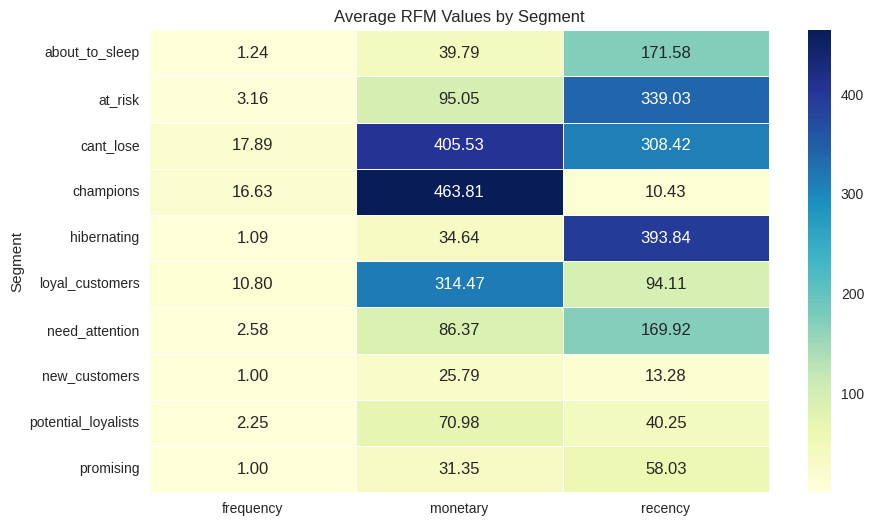

In [ ]:
pivot_table = rfm.pivot_table(
    values=['monetary', 'frequency', 'recency'],
    index='segment',
    aggfunc='mean'
)
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table,
    annot=True,
    cmap='YlGnBu',
    fmt='.2f',
    linewidths=0.5,
)
plt.title('Average RFM Values by Segment')
plt.ylabel('Segment')
plt.show()

## 💫 Analyzing Segment Skewness and Scale

Let's take a look at our distributions and find the best method to make it more symetrical.

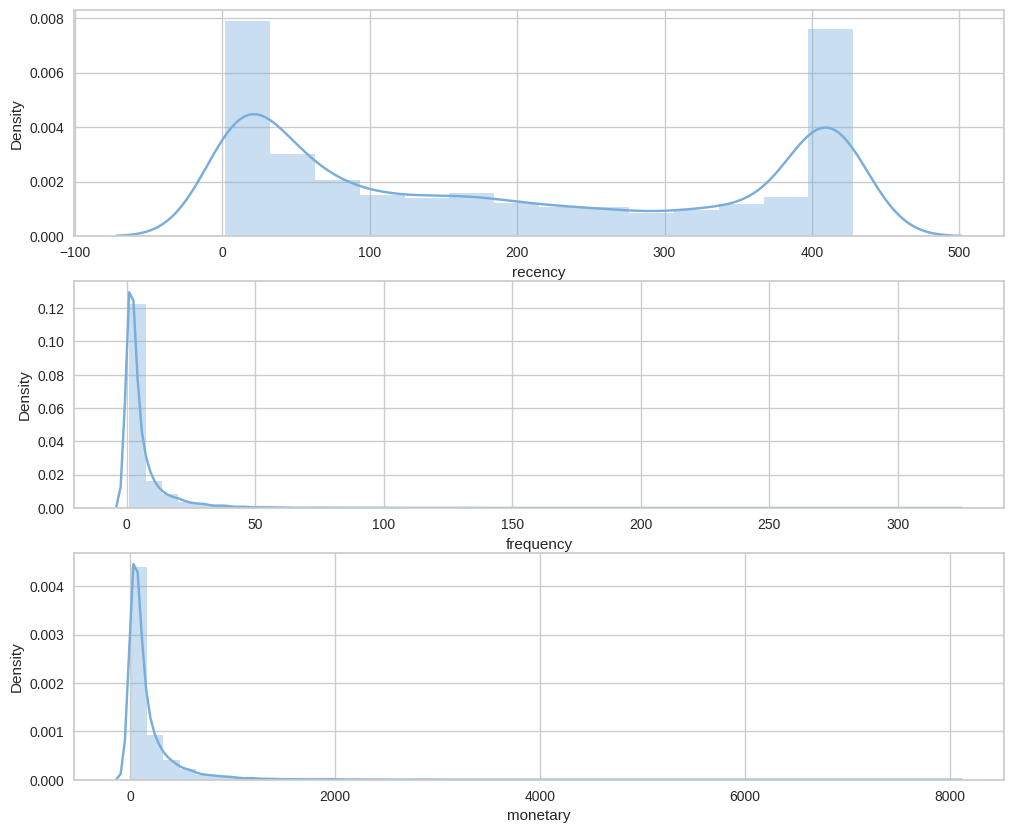

In [ ]:
plt.figure(figsize=(12,10))


plt.subplot(3, 1, 1); sns.distplot(rfm['recency'])
plt.subplot(3, 1, 2); sns.distplot(rfm['frequency'])
plt.subplot(3, 1, 3); sns.distplot(rfm['monetary'])

plt.show()

Based on the previous charts, our distributions seem to be skewed, which raises concerns about the accuracy of our analysis. To address this issue, we need to transform the data into a more symmetrical form. Achieving this requires the use of specific methods to manage the skewness. We will test  **log transformations**, **square root transformations**, and **box-cox transformations** to see which suits our needs better.  

*   **Log transformation** is suitable for variables that have a large range of values, as it compresses the data towards the lower end of the range.
*   **Square root transformation** is ideal for variables with a skewed distribution, as it reduces the skewness and makes the data more symmetrical.
* **Box-cox transformation** is a powerful tool that can handle a wide range of transformations by adjusting the data's power parameter to achieve a more symmetrical distribution. However, it's important to note that these transformations are only suitable for variables that have positive values.

 ✨ By applying these methods, we can achieve a more symmetric distribution that will make it easier to analyze and draw meaningful insights from the data, increasing the accuracy and reliability of our analysis.

In [ ]:
from scipy import stats
def skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

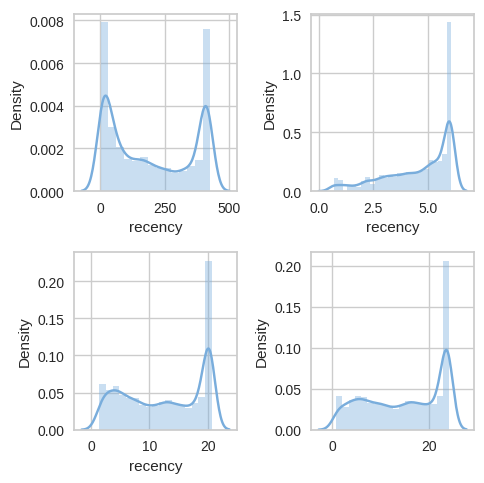

Log Transform : The skew coefficient of 0.22 to -0.92
Square Root Transform : The skew coefficient of 0.22 to -0.16
Box-Cox Transform : The skew coefficient of 0.22 to -0.29


In [ ]:
skewness('recency')


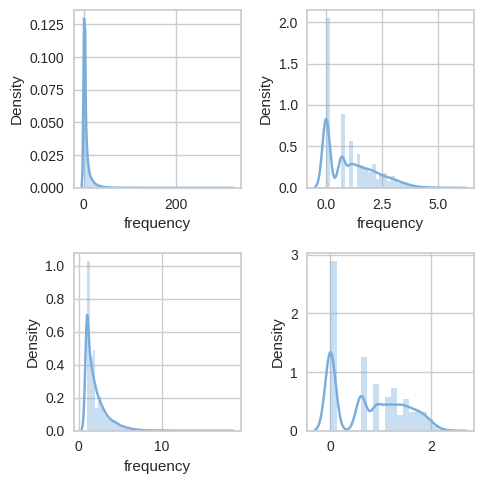

Log Transform : The skew coefficient of 7.39 to 0.71
Square Root Transform : The skew coefficient of 7.39 to 2.25
Box-Cox Transform : The skew coefficient of 7.39 to 0.17


In [ ]:
skewness('frequency')

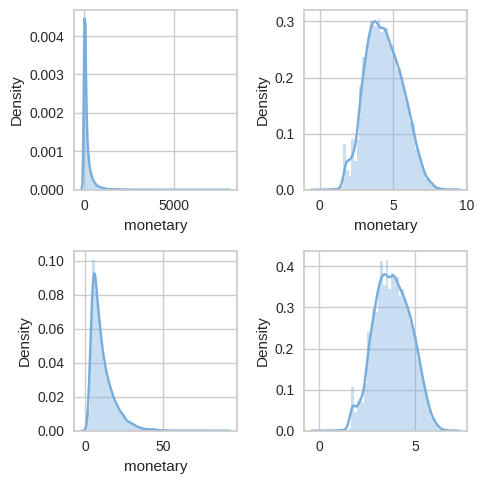

Log Transform : The skew coefficient of 6.65 to 0.19
Square Root Transform : The skew coefficient of 6.65 to 1.95
Box-Cox Transform : The skew coefficient of 6.65 to 0.01


In [ ]:
skewness('monetary')

The graphs presented above illustrate that variables with box-cox transformation exhibit a more symmetrical form compared to other transformations. However, the recency variable already has a low skewness coefficient and therefore, we couldn't observe any significant improvement. As a result, it is advisable to retain its current form. To confirm our findings, we utilized the skew function to calculate each variable.

We can use this transformed data to update the RFM table by running a script that incorporates the newly transformed values.

In [ ]:
rfm_fixed = pd.DataFrame()
rfm_fixed['recency'] = rfm['recency']
rfm_fixed['frequency'] = stats.boxcox(rfm['frequency'])[0]
rfm_fixed['monetary'] = stats.boxcox(rfm['monetary'])[0]
rfm_fixed.tail()

,recency,frequency,monetary
21973,18,0.000000,2.959103
21975,189,1.087539,2.822066
21976,396,0.000000,3.570535
21978,284,0.000000,2.959103
21982,398,0.000000,1.706251


Now, the variables in our dataset have different means and variances, so we need to normalize them. One way to do this is by using the StandardScaler object from the scikit-learn library. This will help us to standardize the variables and make them more comparable.

In [ ]:
scaler =  StandardScaler()
scaler.fit(rfm_fixed)
rfm_normalized = scaler.fit_transform(rfm_fixed)
print(rfm_normalized.mean(axis=0).round(2))
print(rfm_normalized.std(axis=0).round(2))

[-0.  0. -0.]
[1. 1. 1.]


🥳 Our means are equal to zero and the standard deviantion is 1! Great success!

In [ ]:
column_names = ['recency', 'frequency', 'monetary']

rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=column_names)

<Axes: xlabel='recency', ylabel='Density'>

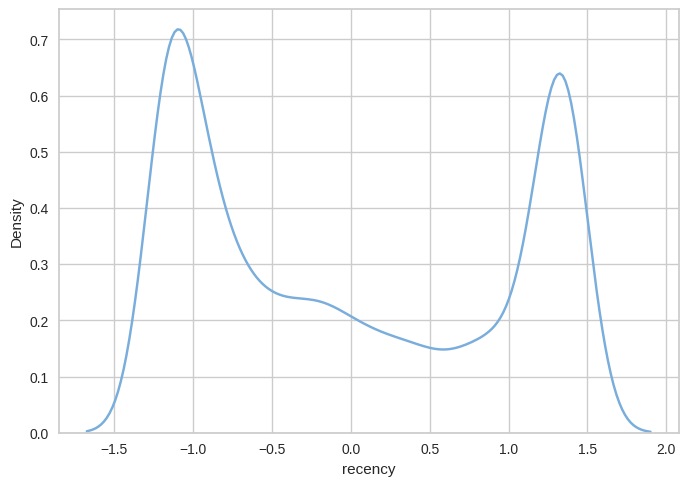

In [ ]:
sns.kdeplot(data=rfm_normalized_df, x="recency")


In [ ]:
rfm_normalized_df.head()

,recency,frequency,monetary
0,-0.846087,-1.160647,-0.585506
1,-0.223066,1.510369,1.603136
2,-1.107756,-1.160647,-1.189012
3,-1.188749,1.510369,1.551900
4,-0.889699,-0.253646,0.339978


Now we can move on to clustering.

## 🌍 K-Means for Clustering

We must determine which hyperparameter fits the data to make our clustering reach its maximum performance. For this, I'm using the elbow method to decide which number of clusters is the best for our model and data.

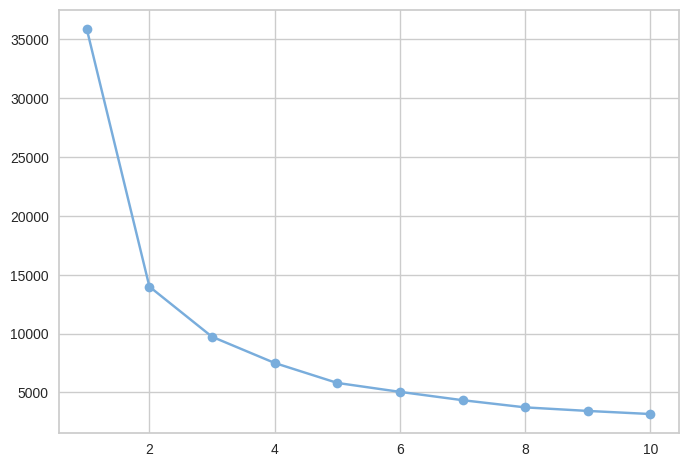

In [ ]:
n_clusters = range(1, 11)
cluster_sse = []
for i in n_clusters:
    kmeans = KMeans(n_clusters= i)
    kmeans.fit(rfm_normalized_df)
    cluster_sse.append(kmeans.inertia_)

plt.plot(n_clusters, cluster_sse, marker = "o")
plt.show()

In [ ]:
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized_df)

    distortions.append(sum(np.min(cdist(rfm_normalized_df, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / rfm_normalized_df.shape[0])
    inertias.append(kmeans.inertia_)

    mapping1[k] = sum(np.min(cdist(rfm_normalized_df, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / rfm_normalized_df.shape[0]

    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
for key, val in mapping1.items():
    print(f'{key} : {val}')


1 : 1.6130285681162588
2 : 0.9931401243751495
3 : 0.8076211765827148
4 : 0.7138822443045977
5 : 0.6263310770365434
6 : 0.5848304395742033
7 : 0.5379385754584695
8 : 0.49971505011490597
9 : 0.47519612973903974
10 : 0.45649014217699263
11 : 0.4381539824190835
12 : 0.4259617869045076
13 : 0.4048391393830481
14 : 0.39325077514448054
15 : 0.3847412005318498
16 : 0.3733015284355913
17 : 0.36474869997363446
18 : 0.3594903811328111
19 : 0.351712525849347


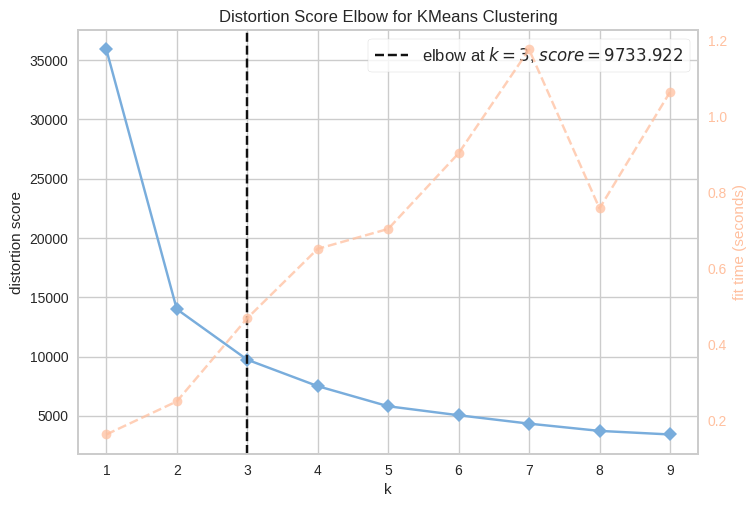

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,10), timings= True)
visualizer.fit(rfm_normalized_df)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

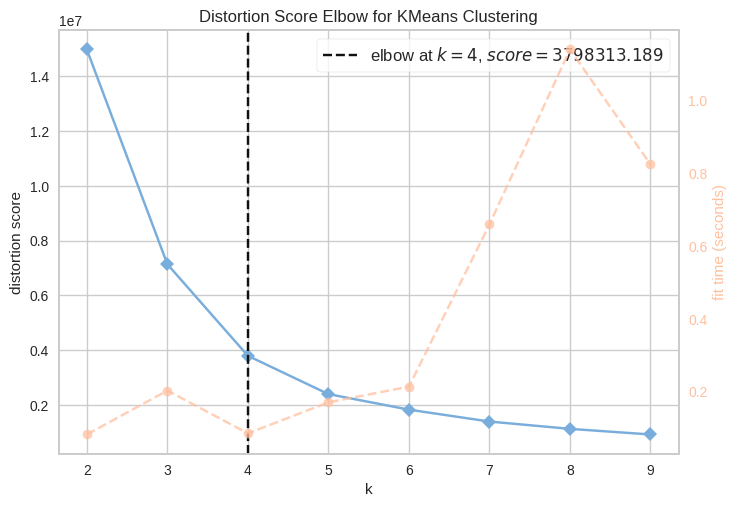

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=42), k=(2, 10))

In [ ]:
X, y = load_nfl()

# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state=42), X, k=(2,10))

It seems that either k=3 or k=4 might fit our needs. Let's take a look at each and decide which gives us a more detailed view of the clients.

**K= 3**

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(rfm_normalized_df)
model.labels_.shape

(11963,)

In [ ]:
rfm.shape

(11963, 9)

In [ ]:
rfm["cluster"] = model.labels_
rfm.head()

,user_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,segment,cluster
1,2,61,1,38.456,4,1,2,41,promising,0
2,3,161,19,631.488,3,5,5,35,loyal_customers,2
7,8,19,1,19.228,5,1,1,51,new_customers,0
12,13,6,19,587.972,5,5,5,55,champions,2
13,14,54,2,118.404,4,2,4,42,potential_loyalists,0


In [ ]:
rfm.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(1)

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0         131.4       2.5     72.5  3662
1         382.4       1.3     37.1  4201
2          65.0      14.3    412.2  4100

 **K=4**

In [ ]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(rfm_normalized_df)
model.labels_.shape

rfm["cluster"] = model.labels_
rfm.head()
rfm.groupby('cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(1)

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0          48.7      14.4    412.9  3973
1         388.9       1.1     30.5  3486
2          84.8       2.0     52.5  2397
3         285.8       3.7    113.3  2107

Based on the tables above, we can compare the distribution of mean values of recency, frequency, and monetary metrics across 3 and 4 clusters. It appears that using k=4 provides a more detailed distribution of our customer base.
Below, we will analyze our data with 4 clusters.

---

### 🪐 Clusters Exploration & Visualization

In [ ]:
df_normalized = pd.DataFrame(rfm_normalized_df, columns=['recency', 'frequency', 'monetary'])
df_normalized['id'] = rfm.index
df_normalized['cluster'] = model.labels_
df_normalized.head()

,recency,frequency,monetary,id,cluster
0,-0.846087,-1.160647,-0.585506,1,2
1,-0.223066,1.510369,1.603136,2,0
2,-1.107756,-1.160647,-1.189012,7,2
3,-1.188749,1.510369,1.551900,12,0
4,-0.889699,-0.253646,0.339978,13,2


In [ ]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['id', 'cluster'],
                      value_vars=['recency','frequency','monetary'],
                      var_name='attribute',
                      value_name='value')
df_nor_melt.head()

,id,cluster,attribute,value
0,1,2,recency,-0.846087
1,2,0,recency,-0.223066
2,7,2,recency,-1.107756
3,12,0,recency,-1.188749
4,13,2,recency,-0.889699


In [ ]:
df_nor_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35889 entries, 0 to 35888
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         35889 non-null  int64  
 1   cluster    35889 non-null  int32  
 2   attribute  35889 non-null  object 
 3   value      35889 non-null  float64
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 981.5+ KB


In [ ]:
# Aggregate data by each customer
fig3 = df_nor_melt.groupby('cluster').agg({'id': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'id': 'count'}, inplace=True)
fig3['percent'] = (fig3['count'] / fig3['count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,cluster,count,percent
0,0,11919,33.2
1,1,10458,29.1
2,2,7191,20.0
3,3,6321,17.6


In [ ]:
fig = px.treemap(fig3, path=['cluster'],values='count'
                 , width=800, height=400
                 ,title="Distribution of Clusters")

fig.update_layout(
    treemapcolorway = colors, #predefined colors on the header of notebook
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

**Recency x Frequency**

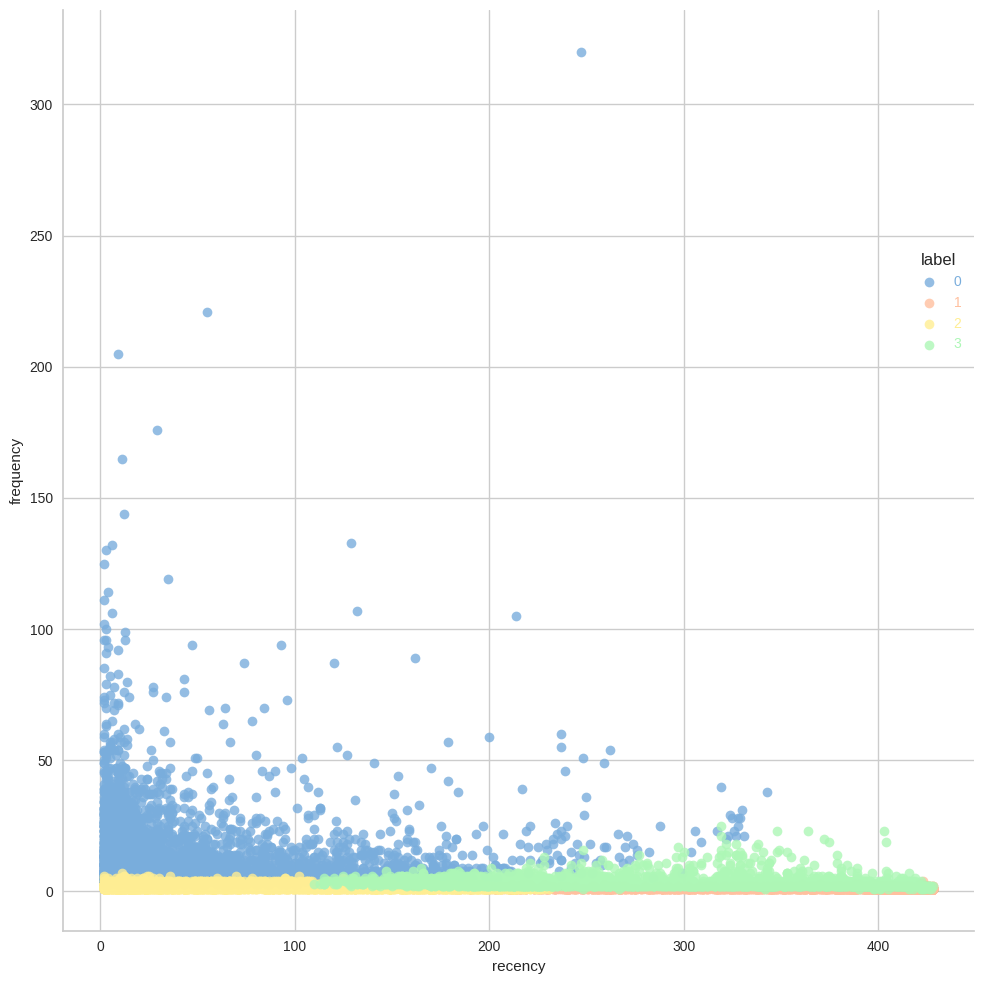

In [ ]:
data = pd.DataFrame(data=rfm,columns=['user_id','cluster','recency','frequency','monetary'])

facet = sns.lmplot(data=data, x='recency', y='frequency', hue='cluster', height=10,
                   fit_reg=False, legend=False)

#add a legend
leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)
# change label colors
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

**Monetary x Frequency**

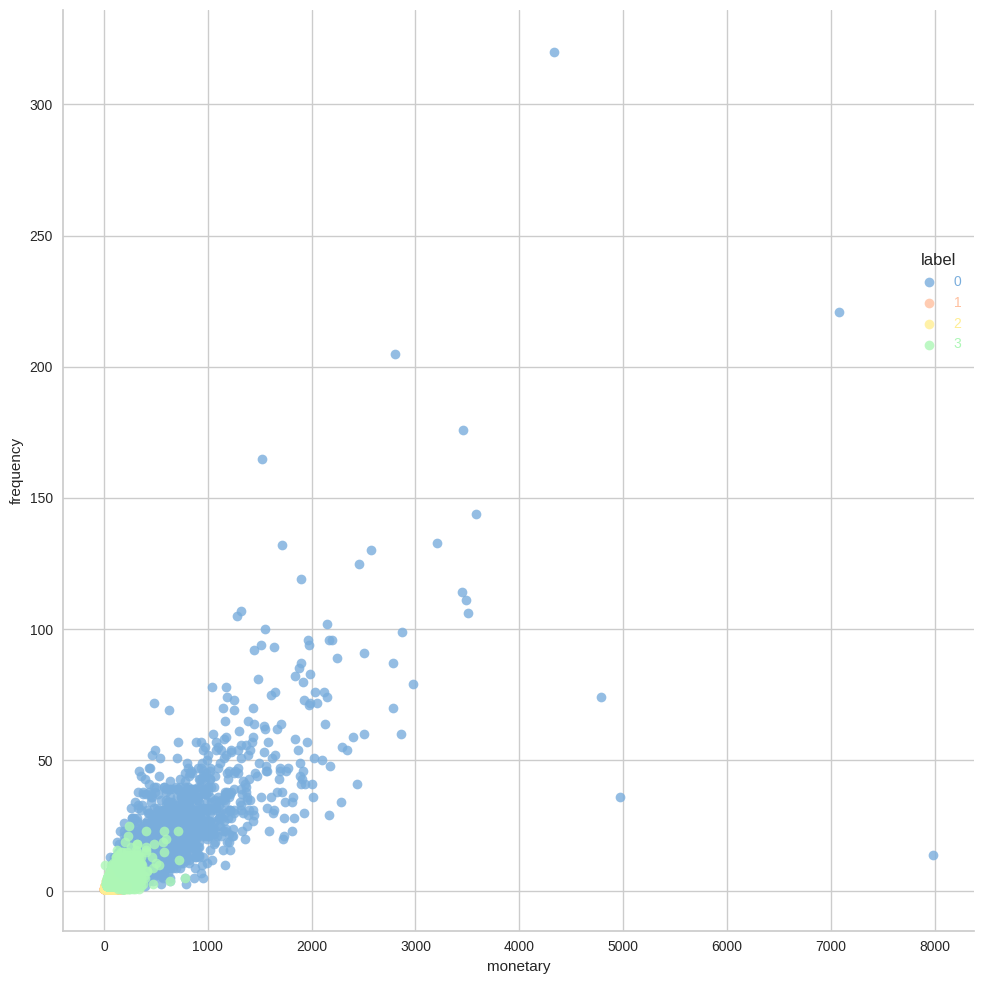

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))
facet = sns.lmplot(data=data, x='monetary', y='frequency', hue='cluster', height=10,
                   fit_reg=False, legend=False)


leg = facet.ax.legend(bbox_to_anchor=[1, 0.75],
                         title="label", fancybox=True)

for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color = customPalette[i])

In [ ]:
fig = px.scatter_3d(rfm,x='recency', y='frequency', z='monetary',
              color='cluster', opacity=0.7,color_discrete_sequence=px.colors.qualitative.Pastel)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## 🌝 Interpreting the Results

In [ ]:
cluster_avg = rfm[['cluster','recency','frequency','monetary']].groupby(['cluster']).mean()
cluster_avg

,recency,frequency,monetary
cluster,,,
0,48.658445,14.352127,412.857028
1,388.897590,1.079174,30.523151
2,84.760951,1.984981,52.488476
3,285.797817,3.706692,113.334394


In [ ]:
# Aggregate data by each customer
rfm1 = rfm.groupby(['cluster','segment'],).agg({'user_id': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'user_id': 'count'}, inplace=True)
rfm1['percent'] = (rfm1['count'] / rfm1.groupby('cluster')['count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(2)

rfm1

,cluster,segment,count,percent
0,0,at_risk,4,0.10
1,0,cant_lose,43,1.08
2,0,champions,1856,46.72
3,0,loyal_customers,1951,49.11
4,0,need_attention,17,0.43
5,0,potential_loyalists,102,2.57
6,1,about_to_sleep,128,3.67
7,1,at_risk,161,4.62
8,1,hibernating,3196,91.68
9,1,need_attention,1,0.03


In [ ]:
rfm.groupby(['cluster'])['recency'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
cluster,,,,,
0,3973,48.658445,27.0,343,2
1,3486,388.897590,408.0,428,161
2,2397,84.760951,71.0,259,2
3,2107,285.797817,289.0,428,110


Cluster | Description
-------------------|------------------
**0** |Customers who made their latest transaction **recently**.
**1** | Customers who made their last transaction a **long time ago**.
**2** | Customers who made their last transaction **a while ago**.
**3** | Customers who made their last transaction a **long time ago**.

In [ ]:
rfm.groupby(['cluster'])['frequency'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
cluster,,,,,
0,3973,14.352127,9.0,320,2
1,3486,1.079174,1.0,4,1
2,2397,1.984981,2.0,7,1
3,2107,3.706692,3.0,25,1


Cluster | Description
-------------------|------------------
**0** |Customers with the **highest** purchase frequency.
**1** | Customers with the **lowest** purchase frequency.
**2** | Customers with a **low** purchase frequency.
**3** | Customers who made **few** purchases.

In [ ]:
rfm.groupby(['cluster'])['monetary'].agg(['count','mean','median','max','min'])

,count,mean,median,max,min
cluster,,,,,
0,3973,412.857028,285.384,7979.620,53.636
1,3486,30.523151,26.312,185.196,1.012
2,2397,52.488476,46.552,218.592,5.060
3,2107,113.334394,93.104,779.240,11.132


Cluster | Description
-------------------|------------------
**0** |Customers with the **highest** spend.
**1** | Customers with the **lowest** purchase spend.
**2** | Customers with a **medium** purchase spend.
**3** | Customers who made **large** purchases.

## ⭐️ Summary of each Cluster

Cluster | % of Total | RFM Labels | Description
-------------------|------------------|------------------|------------------|
**0** |33%|49% Loyal Customers; 46% Champions| Customers who purchase frequently, spend the highest amounts and have recently made a transaction.|
**1** |29%|91% Hibernating|Customers who made their last transaction a long time ago,rarely bought anything, and spent the least.|
**2** |20%|44% Potential Loyalists; 23% About to Sleep| Customers who made their last transaction a while ago, seldom make transactions, but spent a considerable amount.|
**3** |18%|50% At Risk| Customers who made their last transaction a long time ago, have a lower purchase frequency, but made large purchases in the past.|